In [1]:
# import all python packages needed
import numpy as np
from time import time
import re
import os
from tqdm import tqdm
from collections import Counter
from sklearn.datasets import fetch_20newsgroups
from gensim.models import *
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC,SVC
from sklearn.linear_model import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import *
from sklearn.metrics import *
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.sparse import *
import itertools

C:\Users\11207\Anaconda3\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [13]:
#train the Word2vec model on text8 corpus.This may consume 2-3 minutes to run
#you can just skip it to save time
dim=100
sentences=word2vec.Text8Corpus('text8.txt')            #train on the pre-build text8 corpus
w2c_model=Word2Vec(sentences,size=dim,min_count=5,sg=1)       #get the 100 dimensions word vector
w2c_model.save('word2vec_model')


In [6]:
#fetch the 20_newsgroups data and proprocess it,as well as count the word frequency
w2c_model=Word2Vec.load('word2vec_model')
newsgroups_train=fetch_20newsgroups(subset='train')
newsgroups_test=fetch_20newsgroups(subset='test')
newsgroups=fetch_20newsgroups(subset='all')

def preprocess(s):
    s = re.sub(r"[^A-Za-z0-9(),!?\'\-`]", " ", s)
    punc='!,?.@<>()/\:'                                #remove useless punctuation for words split further
    for c in punc:
        s=s.replace(c,' ')
    return s.strip().lower()

stoplist=stopwords.words('english')
clean_train_data=list(map(preprocess,newsgroups_train.data))
fdist = Counter()
for doc in clean_train_data:
    for word in doc.split():
            fdist[word]+=1
            
print(len(fdist))

152323


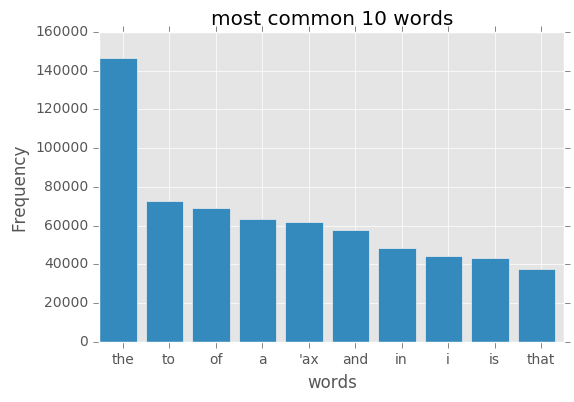

In [7]:
yval=[d[1] for d in fdist.most_common()[:10]]
xval=range(10)
plt.bar(xval,yval)
plt.xticks([0.5+i for i in range(10)],[d[0] for d in fdist.most_common()[:10]])
plt.xlabel('words')
plt.ylabel('Frequency')
plt.title('most common 10 words')
plt.show()

In [8]:
#build the wordvec matrix on all terms
fdist={word:fdist[word] for word in fdist if 
       (fdist[word]>3 and word in w2c_model.wv and word not in stoplist)}
print('There are %d valid words'%(len(fdist)))
word2index={w:i for i,w in enumerate(list(fdist))}
wordvec=np.zeros((len(fdist),100))
for word in word2index:
    wordvec[word2index[word]]=w2c_model.wv[word]


There are 22325 valid words


In [9]:
#cluster the word vectors by kmeans algorithm.This may consume 10-15 minutes to run on an i7-6700HQ CPU
n_cluster=500
kmeans=KMeans(n_clusters=n_cluster,random_state=0).fit(wordvec)

In [10]:
#predict each words in each documents and represent documents by vectors.
#This may consume 11 minutes to run on an i7-6700HQ CPU
doc_train_data=np.zeros((len(clean_train_data),n_cluster))
for i,doc in tqdm(enumerate(clean_train_data)):
    for word in doc.split():
        if word in w2c_model.wv:
            label=kmeans.predict(w2c_model.wv[word].reshape(1,-1))  #assign each words to a cluster
            doc_train_data[i][label]+=1
            


11314it [13:00, 14.50it/s]


In [11]:
#build the w2c_train matrix on trainging set and fit it into SVC algorithm.
w2c_X_train=csr_matrix(doc_train_data)
w2c_y_train=newsgroups_train.target
svc=SVC(kernel='linear',random_state=42)
svc.fit(w2c_X_train,w2c_y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [12]:
#build the w2c_test matrix on testing set and evaluate the performace of classification.
clean_test_data=list(map(preprocess,newsgroups_test.data))
doc_test_data=np.zeros((len(clean_test_data),n_cluster))
for i,doc in tqdm(enumerate(clean_test_data)):
    for word in doc.split():
        if word in w2c_model.wv:
            label=kmeans.predict(w2c_model.wv[word].reshape(1,-1))  #assign each words to a cluster
            doc_test_data[i][label]+=1
            
w2c_X_test=csr_matrix(doc_test_data)
w2c_y_test=newsgroups_test.target
print('The accuracy of word2vec model on testing set is %f'%(svc.score(w2c_X_test,w2c_y_test)))

7532it [08:24, 14.94it/s]


The accuracy of word2vec model on testing set is 0.606745


In [9]:
#Now let's start into TF-IDF model.First build the TF-IDF vector and extract useful features.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')

X_train_=vectorizer.fit_transform(newsgroups_train.data)
y_train_=newsgroups_train.target
chi2_features,_=chi2(X_train_,y_train_)
words_idx= np.argsort(chi2_features)[-10:]
keywords={vectorizer.vocabulary_[word]:word for word in vectorizer.vocabulary_ 
          if vectorizer.vocabulary_[word] in words_idx}

ch2 = SelectKBest(chi2, k=60000)
X_train_=ch2.fit_transform(X_train_,y_train_)



X_test_=vectorizer.transform(newsgroups_test.data)
X_test_=ch2.transform(X_test_)
y_test_=newsgroups_test.target


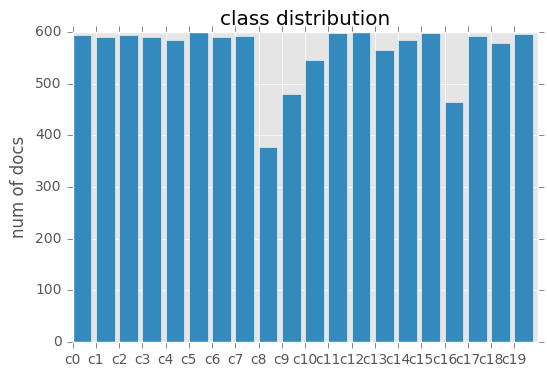

In [13]:
#visualize the class distribution
class_dis=Counter(newsgroups_train.target)
class_dis={newsgroups_train.target_names[i]:class_dis[i] for i in class_dis}
class_dis=list(class_dis.items())
xval=range(20)
yval=[d[1] for d in class_dis]
plt.bar(left=xval,height=yval,width=0.8)
plt.xticks(xval,['c'+str(i) for i in xval])
plt.ylabel('num of docs')
plt.title('class distribution')
plt.show()

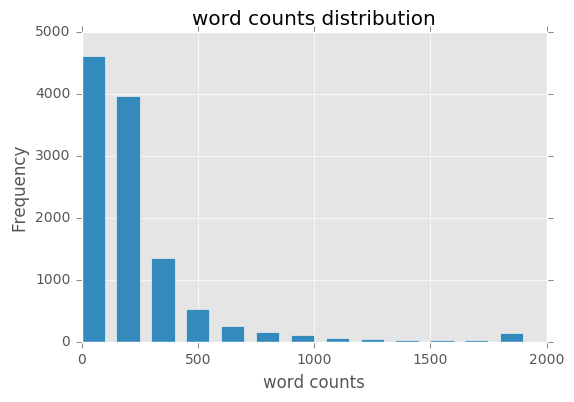

In [14]:
#visualize the word count distribution
xval=range(0,1950,150)
len_dis=[len(doc.split()) for doc in newsgroups_train.data]
yval=np.zeros(13)
for length in len_dis:
    if length//150>12:
        yval[-1]+=1
    else:
        yval[length//150]+=1

    
plt.bar(left=xval,height=yval,width=100)
plt.ylabel('Frequency')
plt.xlabel('word counts')
plt.title('word counts distribution')
plt.show()

In [51]:
#training the neural network with 100,300,500 or 700 hidden units and record tneir perforamce.
#This may consume over 30 minutes to run on an i7-6700HQ CPU.You can just skip it to save time.
nacc=[]
ntime=[]
for i in [100,300,500,700]:
    clf10=MLPClassifier(hidden_layer_sizes=(i,),learning_rate='invscaling',
                        tol=1e-4,verbose=True,early_stopping=True)
    t0=time()
    clf10.fit(X_train_,y_train_)
    dur=time()-t0
    ntime.append(dur)
    nacc.append(clf10.score(X_test_,y_test_))

print(nacc)
print(ntime)

Iteration 1, loss = 2.75182034
Validation score: 0.830389
Iteration 2, loss = 1.78150141
Validation score: 0.916961
Iteration 3, loss = 0.85804315
Validation score: 0.935512
Iteration 4, loss = 0.40384079
Validation score: 0.940813
Iteration 5, loss = 0.21591500
Validation score: 0.940813
Iteration 6, loss = 0.12952732
Validation score: 0.943463
Iteration 7, loss = 0.08513485
Validation score: 0.943463
Iteration 8, loss = 0.06000024
Validation score: 0.946113
Iteration 9, loss = 0.04503430
Validation score: 0.946113
Iteration 10, loss = 0.03547955
Validation score: 0.946996
Iteration 11, loss = 0.02897083
Validation score: 0.944346
Iteration 12, loss = 0.02452105
Validation score: 0.944346
Iteration 13, loss = 0.02120127
Validation score: 0.944346
Validation score did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.50089986
Validation score: 0.901943
Iteration 2, loss = 0.94398150
Validation score: 0.935512
Iteration 3, loss = 0.26778333
V

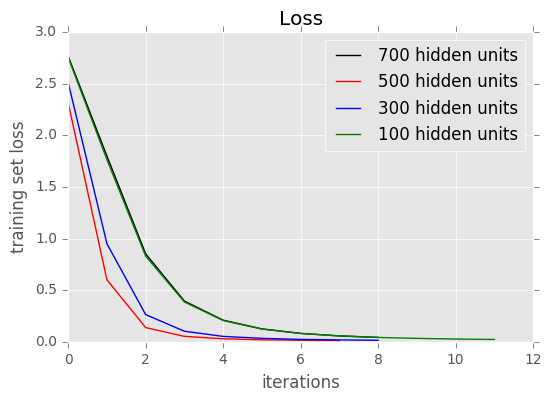

In [16]:
#visualize how the number of hidden units influence the performance of neural network.
#The data below were recorded by print messages when training the neural network.

import matplotlib.pyplot as plt
loss_record_700=[2.7649,1.7987,0.8519,0.3953,0.2106,0.12625,0.0828,0.0585,0.04386]
valid_score_700=[0.8357,0.909,0.931095,0.939046,0.9443,0.94696,0.94696,0.943463,0.946113,0.943463]
loss_record_500=[2.315,0.601,0.139,0.054,0.0304,0.0209,0.0163,0.0137]
valid_score_500=[0.9178,0.9408,0.9478,0.9523,0.9532,0.9496,0.9514]
loss_record_300=[2.5106,0.95055,0.26445,0.10363,0.0536,0.0349,0.0246,0.01956,0.01620]
valid_score_300=[0.90106,0.93286,0.93816,0.9399,0.9399,0.9426,0.9417,0.9426,0.9417]
loss_record_100=[2.7525,1.7636,0.8297,0.3865,0.2073,0.1248,0.0822,0.0582,0.0437,0.0345,0.02828,0.02389]
valid_score_100=[0.8322,0.8869,0.9143,0.9196,0.9205,0.9231,0.92314,0.92314,0.9284,0.9284,0.9267,0.9267]
plt.plot(loss_record_700,label='700 hidden layers',color='black')
plt.plot(loss_record_500,label='500 hidden layers',color='r')
plt.plot(loss_record_300,label='300 hidden layers',color='b')
plt.plot(loss_record_100,label='100 hidden layers',color='g')
plt.legend(('700 hidden units','500 hidden units','300 hidden units','100 hidden units'))
plt.title('Loss')
plt.xlabel('iterations')
plt.ylabel('training set loss')
plt.show()

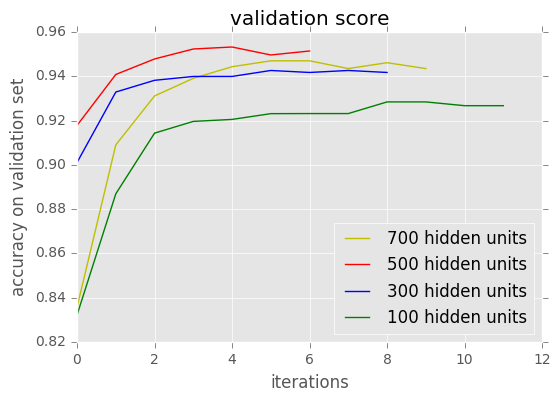

In [17]:
#visulize the validation score changes when training neural network.
plt.plot(valid_score_700,label='700 hidden units',color='y')
plt.plot(valid_score_500,label='500 hidden units',color='r')
plt.plot(valid_score_300,label='300 hidden units',color='b')
plt.plot(valid_score_100,label='100 hidden units',color='g')
plt.legend(loc='lower right')  
plt.title('validation score')
plt.xlabel('iterations')
plt.ylabel('accuracy on validation set')
plt.show()

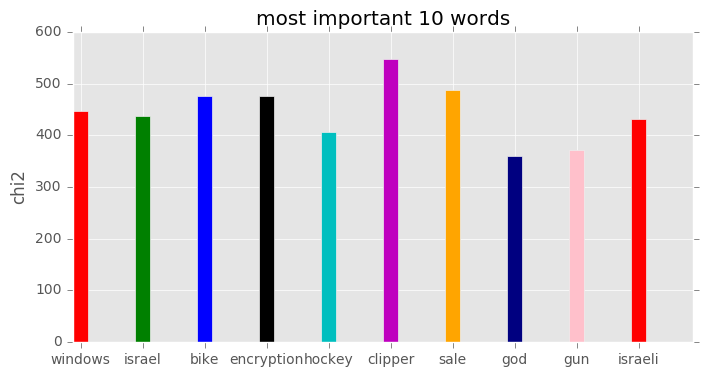

In [19]:
#extract the most important 10 words according to chi2 function and visualize it
words=[]
weights=[]
for i in keywords:
    weights.append(chi2_features[i])
    words.append(keywords[i])
plt.figure(figsize=(8,4))
idx=np.arange(0,10*len(words),10)
plt.bar(idx,weights,width=2.5,color=['r','g','b','k','c','m','orange','navy','pink'])
plt.title('most important 10 words')
plt.xticks(idx+1.3,words)
plt.ylabel('chi2')
plt.show()

In [31]:
#select the best C penalty for LinearSVC
cpara=[0.1,0.5,1.0,2.0,5.0]
for c in cpara:
    classifier=LinearSVC(C=c,loss='squared_hinge',penalty='l2',random_state=1)
    classifier.fit(X_train_,y_train_)
    print('C=%f,accuracy: %f'%(c,classifier.score(X_test_,y_test_)))
        
    

C=0.100000,accuracy: 0.849708
C=0.500000,accuracy: 0.862454
C=1.000000,accuracy: 0.861126
C=2.000000,accuracy: 0.859931
C=5.000000,accuracy: 0.858736


In [32]:
#fit the TF-IDF vector in all six models selected
#This may consume 10 minutes to run on an i7-6700HQ CPU
time_record=[]
clf=[(MultinomialNB(alpha=0.01),'MultinomialNB'),(RidgeClassifier(alpha=1.25,
                                                                  solver="sag",random_state=1),
                                                 'RidgeClassifier'),
     (PassiveAggressiveClassifier(C=0.5,n_iter=32,loss='squared_hinge',random_state=1),
      'PassiveAggressiveClassifier'),
     (LinearSVC(C=0.5,loss='squared_hinge',penalty='l2',random_state=1),'LinearSVC'),
     (SGDClassifier(alpha=.0001, n_iter=50,penalty='l2',random_state=1),'SGDClassifier'),
     (MLPClassifier(hidden_layer_sizes=(300,),learning_rate='invscaling',
                    random_state=1,tol=1e-4,early_stopping=True),
      'Neural Network')]

for model,name in clf:
    print('%s starts training......'%(name))
    t0=time()
    model.fit(X_train_,y_train_)
    dur=time()-t0
    time_record.append(dur)

MultinomialNB starts training......
RidgeClassifier starts training......
PassiveAggressiveClassifier starts training......
LinearSVC starts training......
SGDClassifier starts training......
Neural Network starts training......


In [33]:
# see the testing set accuracy of every model.
acc_record=[]

for i,c in enumerate(clf):
    acc=c[0].score(X_test_,y_test_)
    print("The accuracy of %s is %f" %(c[1],acc))
    acc_record.append(acc)

The accuracy of MultinomialNB is 0.837095
The accuracy of RidgeClassifier is 0.862321
The accuracy of PassiveAggressiveClassifier is 0.857010
The accuracy of LinearSVC is 0.862454
The accuracy of SGDClassifier is 0.859533
The accuracy of Neural Network is 0.867897


In [34]:
#apply ensumble method using vote strategy.
prediction=np.zeros((X_test_.shape[0],len(clf)))
for i,cl in enumerate(clf):
    prediction[:,i]=cl[0].predict(X_test_)

    
voted=np.zeros(len(prediction))
for i in range(len(voted)):
    voted[i]=Counter(prediction[i]).most_common()[0][0] #choose the label that has been assigned by most classifier

acc=accuracy_score(y_test_,voted)
print('The accuracy of ensemble method is %f'%(acc))

The accuracy of ensemble method is 0.866038


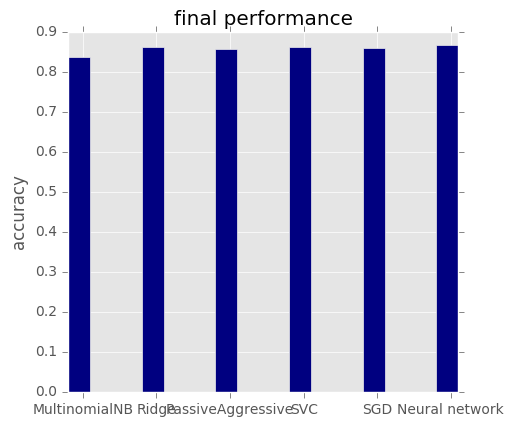

In [35]:
#visualize the final accuracy of different algorithms
idx=np.arange(len(clf))
plt.title('final performance')
plt.xticks(idx+0.2,['MultinomialNB','Ridge','PassiveAggressive','SVC','SGD','Neural network'])
plt.ylabel('accuracy')
plt.bar(idx,acc_record,0.3,label='final performance',color='navy')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)
plt.show()

Normalized confusion matrix


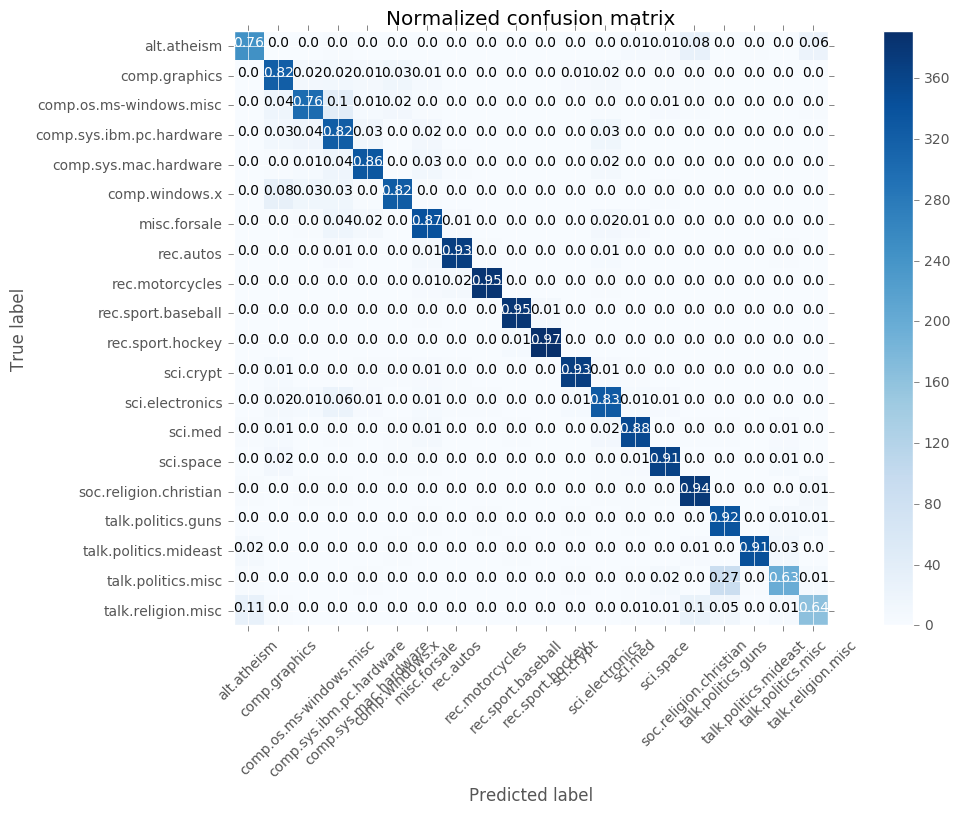

In [50]:
#compute and visualize the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, int(cm[i, j]*100)/100,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)
y_pred=clf[-1][0].predict(X_test_)
cnf_matrix = confusion_matrix(y_test_, y_pred)
plt.figure(figsize=(12,8))
plot_confusion_matrix(cnf_matrix, classes=newsgroups.target_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()